# Climate change in a simple climate model: FaIRv2.0
### PCS/IE, Nov. 2024

# Overview:

In this session we use a simple climate model driven by CO$_{2}$ concentrations or emissions to understand how global-mean temperature responds to idealized changes in atmospheric composition.

Firstly, we examine the response to a instantaneous step-change in CO$_{2}$ concentrations, which is useful for introducing the concept of the *Equilibrium Climate Sensitivity* (or, ECS).

Secondly, we examine the response of global-mean temperature to a "ramp-up" scenario, where we slowly increase the concentration of atmospheric CO$_{2}$ over time. This also helps to motivate a quantity termed the *Transient Climate Response* (or, TCR).

**FaIR model**

The Finite Amplitude Impulse Response (FaIR) model is a simple emissions-based, globally-averaged climate model. It allows the user to input emissions of greenhouse gases and short lived climate forcers in order to estimate global mean **atmospheric GHG concentrations**, **radiative forcing** and **temperature anomalies**. </br>

Read the docs: https://readthedocs.org/projects/fair/downloads/pdf/latest/


## Basic imports

- **Numpy** is a library built on top of C which allows you to perform rapid numerical calculations in Python and generate/manipulate arrays and matrices in a similar way to in MATLAB. <br>


- **Matplotlib** is the canonical plotting package in Python; as you might have guessed by the name, it's basically an open-source version of MATLAB's plotting functions. <br>
    - The '%matplotlib inline' comment just allows normal plotting within the Jupyter notebooks

In [60]:
%matplotlib inline

In [61]:
# Basic imports
import numpy as np
from matplotlib import pyplot as plt

In [62]:
import fair

# Check we're using v2.0.0-alpha
print(f"We're using FaIR version {fair.__version__}") 

# The "engine" of fair is run_fair, stored in the fair.fair_runner class
from fair import *

We're using FaIR version 2.0.0-alpha


# Model set up

FaIR is an impulse response model, structured with a multi-box carbon cycle coupled to a multi-box thermal cycle. Further information on its design can be found here: https://gmd.copernicus.org/articles/14/3007/2021/ 

First we will demonstrate the input/output strucutre of FaIR, so that we can run a simple experiment. 

Next we can explore some of the fundamental properties of any climate model, begining with the thermal cycle's response to a radiative forcing perturbation, and then the carbon cycle's response to an emissions perturbation. Finally we can put these together to estimate the warming response to the time history of pollutants in the climate system, reproducing the best estimate historical warming anomaly. 

## Generating a paramater set

First we can generate a best estimate parameter set to run FaIR with. We can start with just a parameter set for CO2...

In [63]:
co2_gas_params = get_gas_parameter_defaults(choose_gases=['carbon_dioxide'])
therm_params = get_thermal_parameter_defaults()

print(co2_gas_params)
print(therm_params)

                 default
          carbon_dioxide
a1          2.173000e-01
a2          2.240000e-01
a3          2.824000e-01
a4          2.763000e-01
tau1        1.000000e+09
tau2        3.944000e+02
tau3        3.654000e+01
tau4        4.304000e+00
r0          3.390000e+01
rC          1.880000e-02
rT          2.670000e+00
rA          0.000000e+00
PI_conc     2.780000e+02
emis2conc   4.688876e-01
f1          4.570000e+00
f2          0.000000e+00
f3          8.600000e-02
  default                      
        1         2           3
d   0.903  7.920000  355.000000
q   0.180  0.296755    0.385908


## Explaining the thermal cycle parameters

The thermal cycle in FaIRv2.0 is a three-box impulse response model. Here the three 'd' parameters represent timescales (in years) for the decay constants in each 'box' of the model. The 'q' parameters represent the relative weighting of each box in determining the surface temperature response to a given change in radiative forcing. These 'q's don't sum to one, but their sum relate to the expected instantaneous warming anomaly response to a unit radiative forcing change (i.e. q's units: $^{\circ}$C/Wm$^{-2}$).

The standard fair model has three 'd' timescales: one around a year, one around a decade, and one of several hundred years. 

#### Q: why would we expect a model of warming response to have to capture these timescales?

The fair thermal cycle is structured as follows: 

$\frac{dS_j(t)}{dt} = \frac{q_j F(t) - S_j(t)}{d_j}$ 

$T(t) = \sum^{3}_{j=1}S_j$

here F is the radiative forcing which is driving a change in global surface terperature in the model. In essence, this forcing is allocated between the three boxes in the thermal cycle. These boxes don't represent a physical component of the thermal cycle, but you can think of them as a portion of surface temperature which decays to other parts of the thermal cycle at a given rate. There are many processes which dampen a surface temperature anomaly perturbation, with heat being absorbed and stored in the upper ocean, deep ocean, and to a certain extent in the atmosphere and land surface too. 

## Generating an experiment input and running FaIR 

Now we can run a forcing-to-temperature response experiment to see how the thermal response behaves in FaIR...

In [64]:
# How long do we want to run for?
nyears = 550
start_year = 0
end_year = start_year + nyears
# Create empty forcing dataframe
single_stepchangeRF_to_run = return_empty_forcing(start_year=start_year, end_year=end_year)
single_rampRF_to_run = return_empty_forcing(start_year=start_year, end_year=end_year)

print(single_stepchangeRF_to_run)

Scenario       0
Gas      forcing
Year            
0              0
1              0
2              0
3              0
4              0
...          ...
546            0
547            0
548            0
549            0
550            0

[551 rows x 1 columns]


(0.0, 500.0)

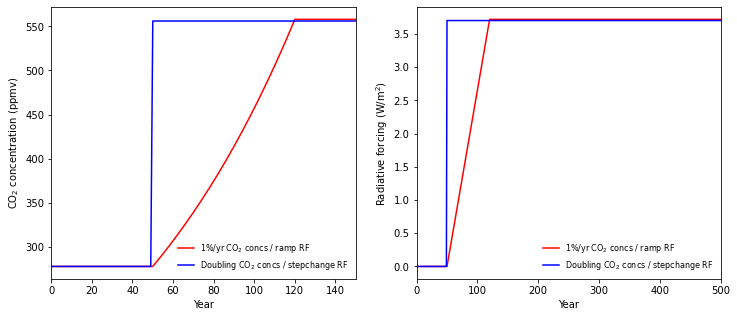

In [65]:
# We are going to generate a forcing timeseries usign a CO2 concentration timeseries. 
# For this we need to set the relationship between radiative forcing and CO2 
# concentrations in FaIR...

# this parameter sets the radiative forcing found after a doubling of CO2 concentrations: 
F_2x = 3.7 # W/m2
# set this into FaIR, and turn off the linear and square-root relationships (f2 = f3 = 0)
co2_gas_params.loc[:,('default','carbon_dioxide')].f1 = F_2x / np.log(2)
co2_gas_params.loc[:,('default','carbon_dioxide')].f2 = 0
co2_gas_params.loc[:,('default','carbon_dioxide')].f3 = 0


""" Generate step-change concentrations scenario """
years = single_stepchangeRF_to_run.index.values

# find preindustrial CO2 concentration value in FaIR gas parameter set
pi_conc = co2_gas_params.loc[:,('default','carbon_dioxide')].PI_conc

# set the step-change experiment to be a doubling of CO2 concentrations from pre-industrial
perturbed_conc = 2*pi_conc

# generate concentrations timeseries which starts at preindustrial 
# concentrations and after 50 years instantaneously doubles and stay there for the next 500 years
concentrations_input = np.ones(years.size)*pi_conc
concentrations_input[50:] = perturbed_conc

# concentrations are related to forcings using a logarithmic relationship:
forcing_input = (F_2x / np.log(2)) * np.log(concentrations_input / pi_conc)

# and load it into the foricng dataframe to run in FaIR
single_stepchangeRF_to_run.loc[:,(0,'forcing')] = forcing_input


""" Generate ramp-up scenario """
# Now repeat but use 1%/yr concentrations increase instead of instantaneous doubling of CO2 concentrations
concentrations1pc_input = np.ones(years.size)*pi_conc
concentrations1pc_input[50:50+70] = pi_conc*1.01**np.arange(0,70)
concentrations1pc_input[50+70:] = pi_conc*1.01**70
# concentrations are related to forcings using a logarithmic relationship:
forcing1pc_input = (F_2x / np.log(2)) * np.log(concentrations1pc_input / pi_conc)
# and load it into the foricng dataframe to run in FaIR
single_rampRF_to_run.loc[:,(0,'forcing')] = forcing1pc_input


# PLOT what we have made... 
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(years, concentrations1pc_input, color='red', label='1%/yr CO$_2$ concs / ramp RF')
ax[0].plot(years, concentrations_input, color='blue', label='Doubling CO$_2$ concs / stepchange RF')
ax[0].legend(loc='lower right', framealpha=0.0, fontsize=8)
ax[0].set_ylabel('CO$_2$ concentration (ppmv)')
ax[0].set_xlabel('Year')
ax[0].set_xlim(0,150)

ax[1].plot(years, single_rampRF_to_run, color='red', label='1%/yr CO$_2$ concs / ramp RF')
ax[1].plot(years, single_stepchangeRF_to_run, color='blue', label='Doubling CO$_2$ concs / stepchange RF')
ax[1].legend(loc='lower right', framealpha=0.0, fontsize=8)
ax[1].set_ylabel('Radiative forcing (W/m$^2$)')
ax[1].set_xlabel('Year')
ax[1].set_xlim(0,500)

### Now run them through FaIR and plot outputs

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 0 and 550...


100%|████████████████████████████████| 550/550 [00:00<00:00, 4048.58 timestep/s]

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 0 and 550...



100%|████████████████████████████████| 550/550 [00:00<00:00, 4162.66 timestep/s]


(0.0, 500.0)

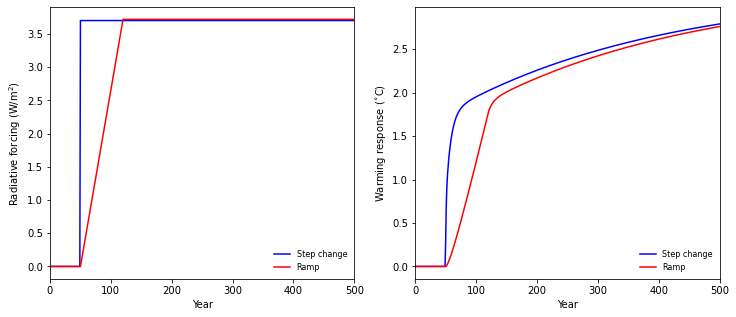

In [66]:
# FaIR needs an emissions input (even if its just zeros...)
empty_co2ems = return_empty_emissions(start_year=start_year, end_year=end_year, gases_in=['carbon_dioxide'])

stepchange_run = run_FaIR(emissions_in=empty_co2ems, forcing_in=single_stepchangeRF_to_run, gas_parameters=co2_gas_params, thermal_parameters=therm_params)
ramp_run = run_FaIR(emissions_in=empty_co2ems, forcing_in=single_rampRF_to_run, gas_parameters=co2_gas_params, thermal_parameters=therm_params)


# PLOT outputs
fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(years, stepchange_run['RF'].loc[:,(0,'default','Total')], color='blue', label='Step change')
ax[0].plot(years, ramp_run['RF'].loc[:,(0,'default','Total')], color='red', label='Ramp')
ax[0].legend(loc='lower right', framealpha=0.0, fontsize=8)
ax[0].set_ylabel('Radiative forcing (W/m$^2$)')
ax[0].set_xlabel('Year')
ax[0].set_xlim(0,500)

ax[1].plot(years, stepchange_run['T'], color='blue', label='Step change')
ax[1].plot(years, ramp_run['T'], color='red', label='Ramp')
ax[1].legend(loc='lower right', framealpha=0.0, fontsize=8)
ax[1].set_ylabel('Warming response ($^{\circ}$C)')
ax[1].set_xlabel('Year')
ax[1].set_xlim(0,500)

From these experiments we define two really iportant parameters in the phyiscal climate system; the transient climate response (TCR) and equilibrium sensitivity (ECS). 

TCR is the transient response to wamring under a 1%/year CO2 concentrations increase experiment, observed in year 70. 

#### Q: Why do we choose year 70, and what is the TCR in this model run? 

The ECS is the equilibrium warming response in the model after it reaches equilibrium following a CO2 concentration doubling. Here you can see that we havent reached equilibrum yet. 

#### Q: Can you go back and adjust the experiment length to see what the ECS approaches in this model run?



## Changing the parameters and seeing the impact...

Now we have a model run, we can start to change parameters and see teh impact on the result.

Lets vary the ECS and TCR:

Example ECS range: [2.5 - 4.0] $^{\circ}$C

Example TCR range: [1.4 - 2.2] $^{\circ}$C

Old therm params
   default                      
        1         2           3
d   0.903  7.920000  355.000000
q   0.180  0.296755    0.385908 

New therm params
   default                      
        1         2           3
d   0.903  7.920000  355.000000
q   0.180  0.611684    0.272428 


Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 0 and 550...


100%|████████████████████████████████| 550/550 [00:00<00:00, 3396.87 timestep/s]

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 0 and 550...



100%|████████████████████████████████| 550/550 [00:00<00:00, 3902.24 timestep/s]


(0.0, 500.0)

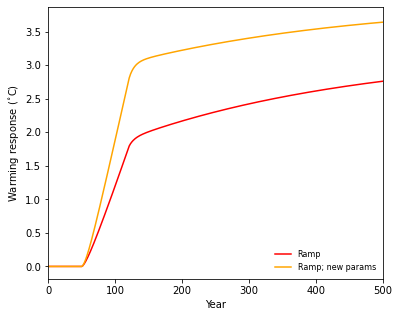

In [67]:
# Choose a TCR value, ECS value:
TCR_val = 2.8
ECS_val = 4.0
new_therm_params = get_thermal_parameter_defaults(TCR=TCR_val, RWF=TCR_val/ECS_val)

# lets look at how this has changed the underlying 'q' and 'd' parameters: 
print('Old therm params\n', therm_params, '\n')
print('New therm params\n', new_therm_params, '\n\n')

# and rerun FaIR:
stepchange_run_newparams = run_FaIR(emissions_in=empty_co2ems, forcing_in=single_stepchangeRF_to_run, gas_parameters=co2_gas_params, thermal_parameters=new_therm_params)
ramp_run_newparams = run_FaIR(emissions_in=empty_co2ems, forcing_in=single_rampRF_to_run, gas_parameters=co2_gas_params, thermal_parameters=new_therm_params)

# PLOT outputs
fig, ax = plt.subplots(1,1,figsize=(6,5))

# ax.plot(years, stepchange_run['T'], color='blue', label='Step change')
# ax.plot(years, stepchange_run_newparams['T'], color='skyblue', label='Step change; new params')
ax.plot(years, ramp_run['T'], color='red', label='Ramp')
ax.plot(years, ramp_run_newparams['T'], color='orange', label='Ramp; new params')
ax.legend(loc='lower right', framealpha=0.0, fontsize=8)
ax.set_ylabel('Warming response ($^{\circ}$C)')
ax.set_xlabel('Year')
ax.set_xlim(0,500)

#### Q: How does changing these parameters change the results, and in what ways does it not change them? 

#### Q: which of these parameters do we have best knowledge of? Which do we know least about?

#### Q: find what warming occurs under different levels of peak CO2 concentration values (perturbed_conc in above code). (For an idea of values that may actually occur, note that current levels are approximately 400ppm, some pressure groups call for a target of 350ppm, and concentrations reach about 1200ppm at the end of the 21st century under the RCP8.5 scenario)

## The carbon cycle and emissions driven experiments 

The carbon cycle is another impulse response structure in FaIR. The form is:

$\frac{dR_i(t)}{dt} = a_iE(t) - \frac{R_i}{\alpha \tau_i}$ 

$C(t) = C_{preind} + \sum^{4}_{i=1}R_i(t)$

alpha is a parameter which sets the extent of non-linearities in the carbon cycle response to a CO2 emissions perturbation. It depends on the cumulative emissions to date which reside in the ocean and biosphere, and the global surface temperature anomaly. Other parameters are defined in the co2_gas_params variable above.

With this addition we have a way to run emissions driven experiments in FaIR: 

Text(0, 0.5, 'CO$_2$ emissions (GtC/yr)')

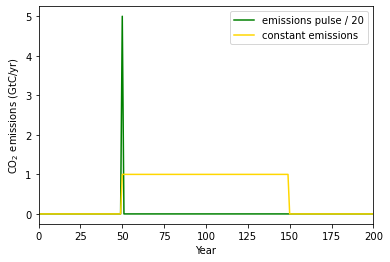

In [98]:
# Now lets run some emissions driven experiments:
years = np.arange(0,201)

# define an 100GtC CO2 emissions pulse
co2_emissions_pulse = return_empty_emissions(start_year=0, end_year=200, gases_in=['carbon_dioxide'])
# set a pulse at yeaer 50
co2_emissions_pulse.loc[50,(0,'carbon_dioxide')] = 100

# define a 1GtC 100 year constant emissions experiment
co2_emissions_const = return_empty_emissions(start_year=0, end_year=200, gases_in=['carbon_dioxide'])
# set a 1 GtC emission for 100 years starting in year 50
co2_emissions_const.loc[50:149,(0,'carbon_dioxide')] = 1

plt.plot(years, co2_emissions_pulse/20, color='green', label='emissions pulse / 20')
plt.plot(years, co2_emissions_const, color='gold', label='constant emissions')
plt.legend(loc='best')
plt.xlim(0,200)
plt.xlabel('Year')
plt.ylabel('CO$_2$ emissions (GtC/yr)')

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 0 and 200...


100%|████████████████████████████████| 200/200 [00:00<00:00, 3554.56 timestep/s]

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 0 and 200...



100%|████████████████████████████████| 200/200 [00:00<00:00, 3342.37 timestep/s]


(0.0, 200.0)

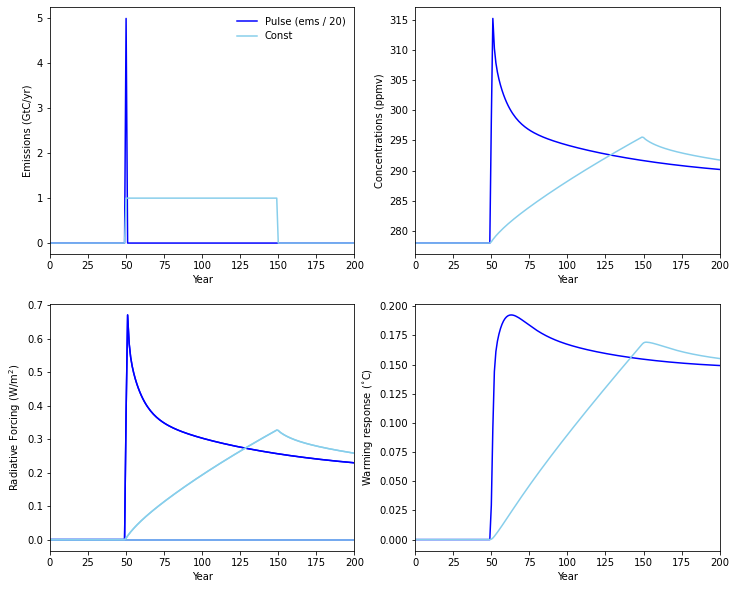

In [105]:
# and run FaIR
pulse_run = run_FaIR(emissions_in=co2_emissions_pulse, gas_parameters=co2_gas_params, thermal_parameters=therm_params)
const_run = run_FaIR(emissions_in=co2_emissions_const, gas_parameters=co2_gas_params, thermal_parameters=therm_params)

# PLOT outputs
fig, ax = plt.subplots(2,2,figsize=(12,10))

ax[0,0].plot(years, pulse_run['Emissions']/20, color='blue', label='Pulse (ems / 20)')
ax[0,0].plot(years, const_run['Emissions'], color='skyblue', label='Const')
ax[0,0].legend(loc='upper right', framealpha=0.0, fontsize=10)
ax[0,0].set_ylabel('Emissions (GtC/yr)')
ax[0,0].set_xlabel('Year')
ax[0,0].set_xlim(0,200)

ax[0,1].plot(years, pulse_run['C'], color='blue', label='Pulse')
ax[0,1].plot(years, const_run['C'], color='skyblue', label='Const')
ax[0,1].set_ylabel('Concentrations (ppmv)')
ax[0,1].set_xlabel('Year')
ax[0,1].set_xlim(0,200)

ax[1,0].plot(years, pulse_run['RF'], color='blue', label='Pulse')
ax[1,0].plot(years, const_run['RF'], color='skyblue', label='Const')
ax[1,0].set_ylabel('Radiative Forcing (W/m$^2$)')
ax[1,0].set_xlabel('Year')
ax[1,0].set_xlim(0,200)

ax[1,1].plot(years, pulse_run['T'], color='blue', label='Pulse')
ax[1,1].plot(years, const_run['T'], color='skyblue', label='Const')
ax[1,1].set_ylabel('Warming response ($^{\circ}$C)')
ax[1,1].set_xlabel('Year')
ax[1,1].set_xlim(0,200)

#### Q: In the two experiments the same amount of CO2 is ultimately emitted into the atmosphere (100GtC). Why is the response different between the two? 

#### Q: Can you estimate the TCRE? Roughly, this is the transient warming in response to a 1000 !!GtCO2!! (not GtC) emission experiment. 
Technically, the TCRE is estimated using a 1%/yr CO2 concentration increase experiment, with the corresponding emissions timeseries backed out offline. You can see that in most cases this doesnt matter (plot cumulative CO2 emissions against temperature response...)

## The TCRE and global warming

Putting it all together, we can estimate historical warming and compare it to observations of global mean surface temperature



Text(0.5, 0, 'Cumulative CO$_2$ emissions (GtC)')

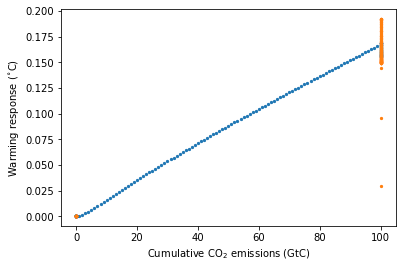

In [126]:
# the TCRE can be estimated using the gradient of a plot of cumulative CO2 emissions and temperature

plt.scatter(np.cumsum(const_run['Emissions']), const_run['T'], s=20, marker='.')
plt.scatter(np.cumsum(pulse_run['Emissions']), pulse_run['T'], s=20, marker='.')

plt.ylabel('Warming response ($^{\circ}$C)')
plt.xlabel('Cumulative CO$_2$ emissions (GtC)')

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 1850 and 2018...


100%|████████████████████████████████| 168/168 [00:00<00:00, 3084.61 timestep/s]

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 1850 and 2018...



100%|████████████████████████████████| 168/168 [00:00<00:00, 3385.66 timestep/s]

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 1850 and 2018...



100%|████████████████████████████████| 168/168 [00:00<00:00, 3347.36 timestep/s]

Integrating 1 scenarios, 1 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 1850 and 2018...

100%|████████████████████████████████| 168/168 [00:00<00:00, 3295.60 timestep/s]


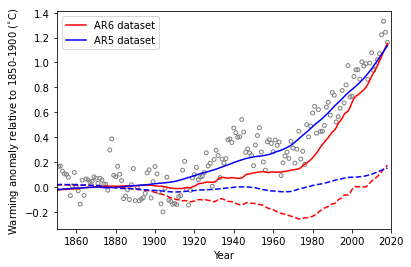

In [199]:
# Lets load historical CO2 emissions into FaIR and run them with
# an estimate of non-CO2 forcing...

# first loading historial CO2 emissions between 1850 and 2018
GCB = pd.read_csv('../data/Global_Carbon_Budget_2019v1.0.csv')
historical_co2_ems = GCB['fossil fuel and industry'].loc[1850-1750:2018-1750] + GCB['land-use change emissions'].loc[1850-1750:2018-1750]
co2_hist = return_empty_emissions(start_year=1850, end_year=2018, gases_in=['carbon_dioxide'])
co2_hist.loc[:,(0,'carbon_dioxide')] = historical_co2_ems.values

# next adding AR6 non-CO2 radiative forcing between 1850-2018
ar6_erf = pd.read_csv('../data/AR6_ERF_1750-2019.csv', index_col='year')
nonco2_erf = ar6_erf['total_anthropogenic'].loc[1850:2018].values - ar6_erf['co2'].loc[1850:2018].values
nonco2_hist = return_empty_forcing(start_year=1850, end_year=2018)
nonco2_hist.loc[:,(0,'forcing')] = nonco2_erf

# or instead RCP non-CO2 RF data 1850-2018
rcp3pd_erf = pd.read_csv('../data/RCP3PD_MIDYEAR_RADFORCING.csv', skiprows=58)
nonco2_erf_rcp = rcp3pd_erf['TOTAL_ANTHRO_RF'].loc[1850-1765:2018-1765].values - rcp3pd_erf['CO2_RF'].loc[1850-1765:2018-1765].values
nonco2_hist_rcp = return_empty_forcing(start_year=1850, end_year=2018)
nonco2_hist_rcp.loc[:,(0,'forcing')] = nonco2_erf_rcp

# running fair and comparing to historical temperature (HadCRUT5 infilled GMST) observations
hist_run_rcp = run_FaIR(emissions_in=co2_hist, forcing_in=nonco2_hist_rcp, gas_parameters=co2_gas_params, thermal_parameters=therm_params)
hist_run_ar6 = run_FaIR(emissions_in=co2_hist, forcing_in=nonco2_hist, gas_parameters=co2_gas_params, thermal_parameters=therm_params)

hist_run_rcp_nonco2 = run_FaIR(emissions_in=return_empty_emissions(start_year=1850,end_year=2018,gases_in=['carbon_dioxide']), forcing_in=nonco2_hist_rcp, gas_parameters=co2_gas_params, thermal_parameters=therm_params)
hist_run_ar6_nonco2 = run_FaIR(emissions_in=return_empty_emissions(start_year=1850,end_year=2018,gases_in=['carbon_dioxide']), forcing_in=nonco2_hist, gas_parameters=co2_gas_params, thermal_parameters=therm_params)

# add historical GMST from HadCRUT5
hadcrut5 = pd.read_csv('../data/HadCRUT5_infilled_global.csv')
plt.scatter(np.arange(1850,2019), hadcrut5['ann'].dropna() - np.mean(hadcrut5['ann'].dropna().loc[1850-1750:1900-1750]), color='grey', s=15, marker='o', facecolor='none')

# plot the total warming response under each non-CO2 forcing assumption
plt.plot(np.arange(1850,2019), hist_run_ar6['T'] - np.mean(hist_run_ar6['T'].loc[1850:1900]), color='red', label='AR6 dataset')
plt.plot(np.arange(1850,2019), hist_run_rcp['T'] - np.mean(hist_run_rcp['T'].loc[1850:1900]), color='blue', label='AR5 dataset')

# plot the non-CO2 contribution under each non-CO2 forcing assumption
plt.plot(np.arange(1850,2019), hist_run_ar6_nonco2['T'] - np.mean(hist_run_ar6_nonco2['T'].loc[1850:1900]), color='red', linestyle='--')
plt.plot(np.arange(1850,2019), hist_run_rcp_nonco2['T'] - np.mean(hist_run_rcp_nonco2['T'].loc[1850:1900]), color='blue', linestyle='--')

plt.ylabel('Warming anomaly relative to 1850-1900 ($^{\circ}$C)')
plt.xlabel('Year')
plt.xlim(1850,2020)
plt.legend(loc='best')

#### Q: Why would the AR6 data appear to be a worse fit to the data? What could resolve this discrepancy? 

#### Q: Here is a dataset for a future forcing trajectory (SSP119). Can you code it up to run in fair? 

#### Q: whats the peak warming and 2100 warming anomaly? 

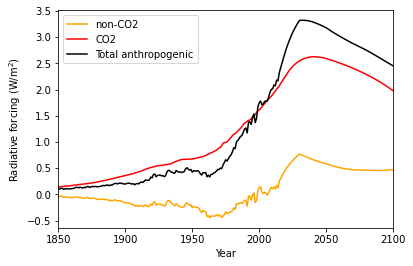

In [204]:
ssp_erf = pd.read_csv('../data/ERF_ssp119_1750-2500.csv', index_col='year')
anthro_erf = ssp_erf['total_anthropogenic'].loc[1850:2100].values
anthro_scen = return_empty_forcing(start_year=1850, end_year=2100)
anthro_scen.loc[:,(0,'forcing')] = anthro_erf

co2_erf = ssp_erf['co2'].loc[1850:2100].values
co2_scen = return_empty_forcing(start_year=1850, end_year=2100)
co2_scen.loc[:,(0,'forcing')] = co2_erf

nonco2_erf = ssp_erf['total_anthropogenic'].loc[1850:2100].values - ssp_erf['co2'].loc[1850:2100].values
nonco2_scen = return_empty_forcing(start_year=1850, end_year=2100)
nonco2_scen.loc[:,(0,'forcing')] = nonco2_erf

plt.plot(np.arange(1850,2101), nonco2_scen, color='orange', label='non-CO2')
plt.plot(np.arange(1850,2101), co2_scen, color='red', label='CO2')
plt.plot(np.arange(1850,2101), anthro_scen, color='black', label='Total anthropogenic')
plt.ylabel('Radiative forcing (W/m$^2$)')
plt.xlabel('Year')
plt.xlim(1850,2100)
plt.legend(loc='upper left')